# Importing Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Read the data

In [22]:
drift = pd.read_csv('data/drift_data.csv')
excursion_data = pd.read_csv('data/excursion_data.csv')

drift_data = drift.copy()

# Data pre-processing

In [23]:
X = drift_data.drop(columns=['outcome'])
y = drift_data['outcome']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# XBG Model without Cross validation

In [24]:
model = xgb.XGBRegressor(
    random_state=42)  
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

RMSE: 0.1194
R^2 Score: 0.9529


In [25]:
importance = model.feature_importances_
feature_importance = sorted(zip(X.columns, importance), key=lambda x: x[1], reverse=True)

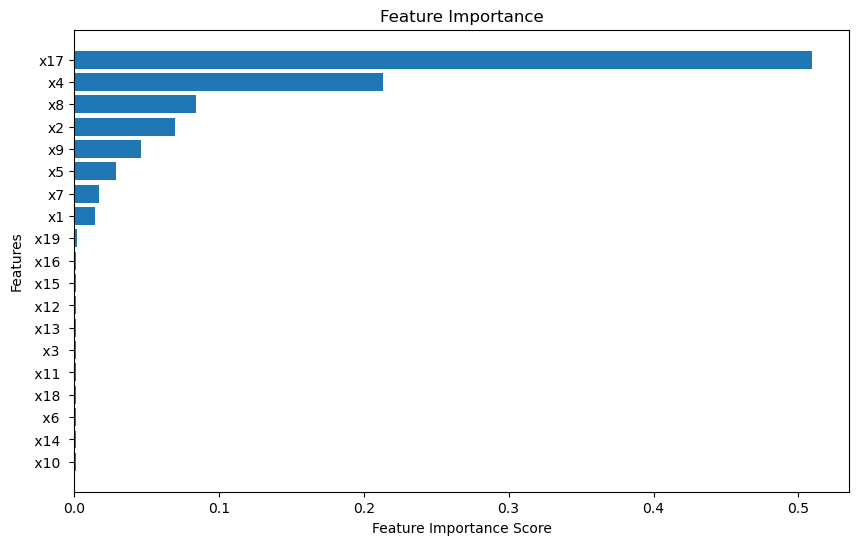

In [26]:
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in feature_importance], [x[1] for x in feature_importance])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Tuned XGB without Cross Validation

In [27]:
model_wt = xgb.XGBRegressor(
    random_state=42,
    n_estimators=100, 
    learning_rate=0.1,  
    max_depth=6)  
model_wt.fit(X_train, y_train)

y_pred_wt = model_wt.predict(X_test)

rmse_wt = np.sqrt(mean_squared_error(y_test, y_pred_wt))
r2_wt = r2_score(y_test, y_pred_wt)

print(f"RMSE: {rmse_wt:.4f}")
print(f"R^2 Score: {r2_wt:.4f}")

RMSE: 0.0962
R^2 Score: 0.9694


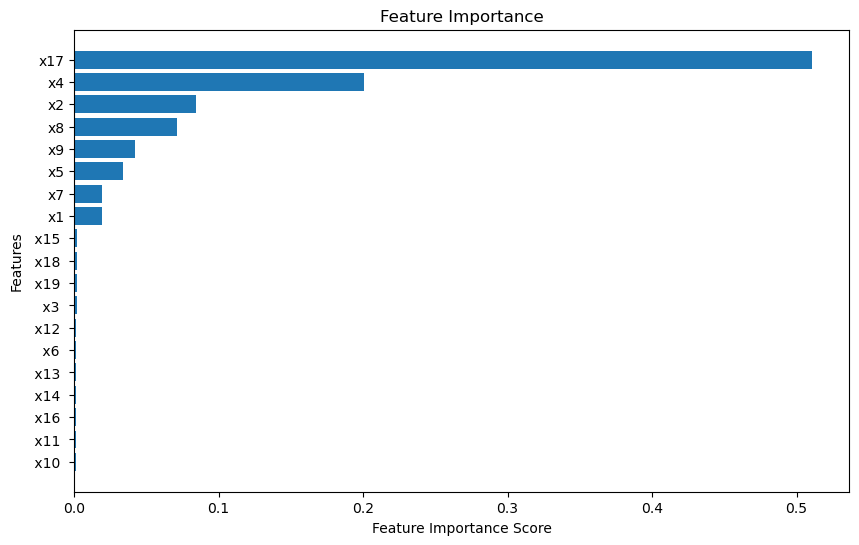

In [28]:
importance_wt = model_wt.feature_importances_
feature_importance_wt = sorted(zip(X.columns, importance_wt), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in feature_importance_wt], [x[1] for x in feature_importance_wt])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Models with Cross Validation

In [29]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grids
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
        "subsample": [0.8, 1.0]
    }
}

# Initialize models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, objective="reg:squarederror")
}

In [30]:
results = {}
best_params = {}
feature_importances = {}

for name, model in models.items():
    print(f"Performing hyperparameter tuning for {name}...")
    grid_search = GridSearchCV(
        model, param_grid=param_grids[name], scoring="neg_mean_squared_error", cv=cv, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    # Get best model and evaluate on test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    best_params[name] = grid_search.best_params_
    results[name] = {
        "Test RMSE": rmse,
        "Test R^2": r2
    }

    # Extract feature importance
    if name == "Random Forest":
        importance = best_model.feature_importances_
    elif name == "XGBoost":
        importance = best_model.feature_importances_

    feature_importances[name] = importance
    
    # Plot Feature Importance
    sorted_idx = np.argsort(importance)[::-1]
    sorted_features = np.array(X.columns)[sorted_idx]
    sorted_importances = importance[sorted_idx]
    
    plt.figure(figsize=(8, 6))
    plt.barh(sorted_features, sorted_importances, color="lightyellow", edgecolor="black")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.title(f"{name} - Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Plot Predicted vs Actual
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=y_test, y=y_pred, color="coral", edgecolor="k")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=1.5, label="Ideal")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} - Predicted vs Actual")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    print(f"{name} Test RMSE: {rmse:.4f}, Test R^2: {r2:.4f}")


Performing hyperparameter tuning for Random Forest...


KeyboardInterrupt: 

In [13]:
print("\nResults Summary:")
results_df = pd.DataFrame(results).T
print(results_df)

print("\nBest Hyperparameters:")
for name, params in best_params.items():
    print(f"{name}: {params}")


Results Summary:
               Test RMSE  Test R^2
Random Forest   0.160529  0.914738
XGBoost         0.059996  0.988090

Best Hyperparameters:
Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


# Rebuilding the model

In [15]:
drift_data_new = drift_data.copy()
drift_data_new.drop(columns=[' x3 ', ' x6 ', ' x10 ', ' x11 ', ' x12 ', ' x13 ',
                              ' x14 ', ' x15 ', ' x16 ', ' x18 ', ' x19 '], axis = 1, inplace=True)

drift_data_new

,x1,x2,x4,x5,x7,x8,x9,x17,outcome
0,21.943154,48.334082,0.413082,140970.006165,1323.187367,99.139588,464.862539,5035.101252,3.148122
1,22.501558,48.011356,0.362717,133825.511764,1304.377437,90.174262,467.774877,5050.664245,3.473297
2,21.063405,42.705805,0.365979,130869.418923,1236.974288,98.593424,454.642424,5421.828263,4.826483
3,21.245647,47.957483,0.345008,124478.889932,1226.385098,85.639395,480.215525,5842.458711,4.877546
4,21.302394,45.400856,0.384472,138729.798021,1159.034721,87.253680,457.376626,5055.359159,3.691299
...,...,...,...,...,...,...,...,...,...
4995,22.079519,43.458963,0.401846,132779.677215,1185.647231,82.373816,482.081081,5866.709121,4.478916
4996,22.636972,44.956826,0.416472,111907.086697,1221.116155,88.488979,460.707512,5974.742452,4.542084
4997,22.204459,45.247144,0.365166,141554.341065,1333.014754,86.903345,463.706679,5428.660301,3.968901
4998,22.202244,48.541081,0.386711,133852.371361,1228.578820,96.878870,445.633861,5358.670063,3.713349


In [16]:
X_new = drift_data_new.drop(columns=['outcome'])
y_new = drift_data_new['outcome']

# Standardize the features
scaler = StandardScaler()
X_scaled_new = scaler.fit_transform(X_new)

# Train-test split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_scaled_new, y_new, test_size=0.1, random_state=42)

In [17]:
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
        "subsample": [0.8, 1.0]
    }
}

# Initialize models
models_new = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, objective="reg:squarederror")
}

Performing hyperparameter tuning for Random Forest...


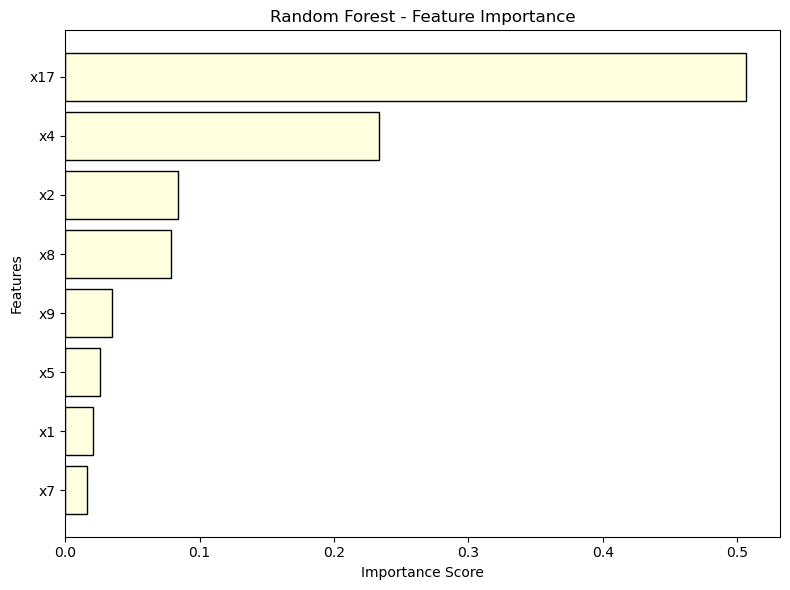

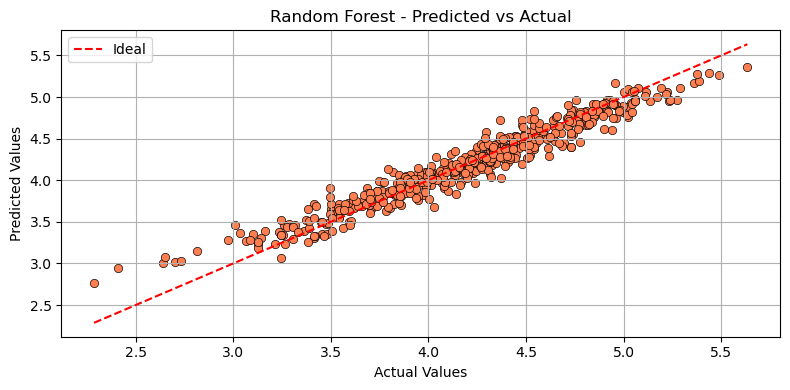

Random Forest Test RMSE: 0.1417, Test R^2: 0.9336
Performing hyperparameter tuning for XGBoost...


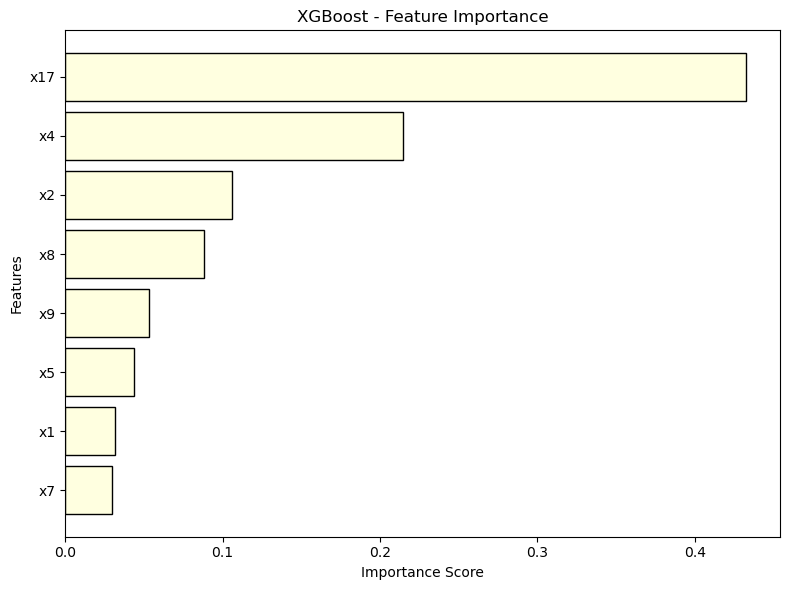

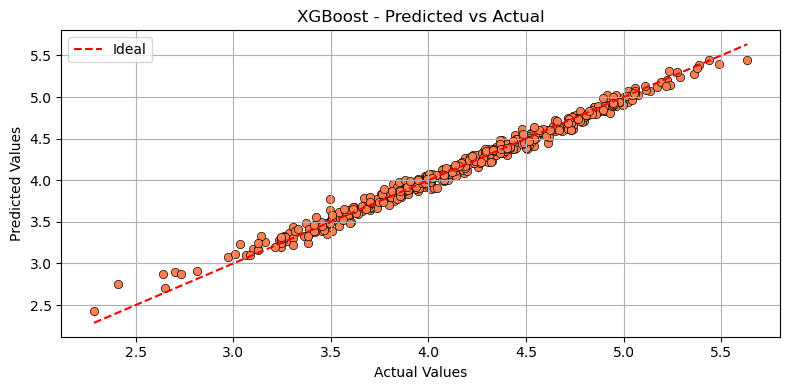

XGBoost Test RMSE: 0.0622, Test R^2: 0.9872


In [ ]:
results = {}
best_params = {}
feature_importances = {}

for name, model in models_new.items():
    print(f"Performing hyperparameter tuning for {name}...")
    grid_search = GridSearchCV(
        model, param_grid=param_grids[name], scoring="neg_mean_squared_error", cv=cv, n_jobs=-1
    )
    grid_search.fit(X_train_new, y_train_new)
    
    # Get best model and evaluate on test set
    best_model = grid_search.best_estimator_
    y_pred_new = best_model.predict(X_test_new)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_new))
    r2 = r2_score(y_test_new, y_pred_new)

    # Store results
    best_params[name] = grid_search.best_params_
    results[name] = {
        "Test RMSE": rmse,
        "Test R^2": r2
    }

    # Extract feature importance
    if name == "Random Forest":
        importance = best_model.feature_importances_
    elif name == "XGBoost":
        importance = best_model.feature_importances_

    feature_importances[name] = importance
    
    # Plot Feature Importance
    sorted_idx = np.argsort(importance)[::-1]
    sorted_features = np.array(X.columns)[sorted_idx]
    sorted_importances = importance[sorted_idx]
    
    plt.figure(figsize=(8, 6))
    plt.barh(sorted_features, sorted_importances, color="lightyellow", edgecolor="black")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.title(f"{name} - Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Plot Predicted vs Actual
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=y_test_new, y=y_pred_new, color="coral", edgecolor="k")
    plt.plot([y_test_new.min(), y_test_new.max()], [y_test_new.min(), y_test_new.max()], '--r', linewidth=1.5, label="Ideal")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} - Predicted vs Actual")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    print(f"{name} Test RMSE: {rmse:.4f}, Test R^2: {r2:.4f}")

In [20]:
print("\nResults Summary:")
results_df = pd.DataFrame(results).T
print(results_df)

print("\nBest Hyperparameters:")
for name, params in best_params.items():
    print(f"{name}: {params}")


Results Summary:
               Test RMSE  Test R^2
Random Forest   0.141661  0.933603
XGBoost         0.062197  0.987201

Best Hyperparameters:
Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


# Testing on Excursion Data

In [33]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [35]:
new_data = excursion_data.copy()  

X_new = new_data.drop(columns=['outcome'])
y_new_actual = new_data['outcome']  

X_new_scaled = scaler.fit_transform(X_new) 

final_model = best_model 
y_new_pred = final_model.predict(X_new_scaled)

# Calculate RMSE and R^2
rmse_final = np.sqrt(mean_squared_error(y_new_actual, y_new_pred))
r2_final = r2_score(y_new_actual, y_new_pred)

In [37]:
print(f"RMSE: {rmse_final:.4f}")
print(f"R^2: {r2_final:.4f}")


RMSE: 3.5930
R^2: -14.8993


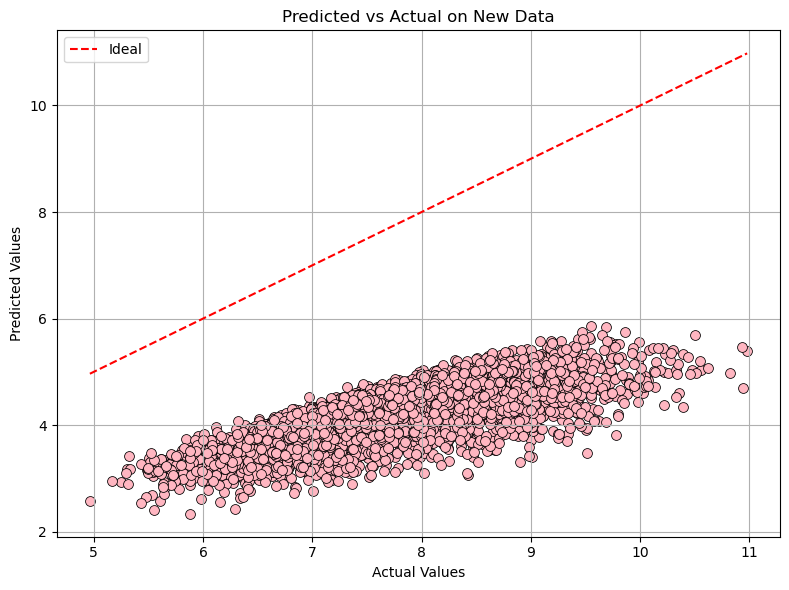

In [38]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_new_actual, y=y_new_pred, color="lightpink", edgecolor="k", s=50)
plt.plot(
    [y_new_actual.min(), y_new_actual.max()],
    [y_new_actual.min(), y_new_actual.max()],
    '--r', linewidth=1.5, label="Ideal"
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual on New Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()